## Inlämning 2 - Machine Learning - Jonathan S
#### This project builds on the previous assignment "Inlämning 1" with the same dataset. Data exploration and identifying cleaning needs has largely been done in the previous assignment.

#### The main goal of this project is to predict 'amount' (column representing customer spending) using the features 'category', 'size' and 'qty'. There is an argument to using more features but in this project I am more focused on learning the fundamentals rather than creating the most optimal model.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pandas option to display all columns when printing df.head()
pd.set_option('display.max_columns', None)

In [59]:
# reading the data 
# converting the 23rd column 'Unnamed 22' column to string, which originally had a mix of bool and NaN values (nan and False)
df = pd.read_csv('AmazonDataSales.csv', dtype={23: str})
df.head(0)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22


### Data Cleaning and Preprocessing

##### The column names are a mess of mixed upper/lowercase, blankspaces and hyphens so in the following block we will clean them and format to snake_case

In [60]:
# clean the column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_')
df.head(0)

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,size,asin,courier_status,qty,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed:_22


#### Getting a better view of the data and how many missing values we have in each column. <br>
- Since we already decided to only use 'category', 'size' and 'qty' as our features, the other columns are not very interesting to us. However, as I found out in the previous assignment, there are some inconsistencies in 'qty' and 'amount' that we need to handle and we might need columns like 'status' and 'courier_status' to help guide those decisions.

In [61]:
# print the shape of the data
print(f'cols, rows: ', df.shape)
# checking for nan values in all columns
print('count of nan values:')
# count of nan values in all columns descending order
print(df.isna().sum().sort_values(ascending=False).head(11))

cols, rows:  (128975, 24)
count of nan values:
fulfilled_by          89698
promotion_ids         49153
unnamed:_22           49050
currency               7795
amount                 7795
courier_status         6872
ship_country             33
ship_postal_code         33
ship_state               33
ship_city                33
ship_service_level        0
dtype: int64


#### Handling the zero values in 'qty' and 'amount'
- Since this is our second go at this dataset we are already familiar with the nature of zero values in 'qty' and 'amount' columns. I have decided to drop the rows with nan values in 'amount' which is 5.9% of total rows, because the all the orders were cancelled as we found out from the 'status' column.


In [62]:
total_rows = df.shape[0]
print(f'total rows: {total_rows}')

# drop rows with null values in 'amount'
df = df.dropna(subset=['amount'])

total_rows_after_drop = df.shape[0]
print(f'total rows after drop: {total_rows_after_drop}')

total rows: 128975
total rows after drop: 121180


#### After running the following codeblock we can see that we have zero values in both 'amount' and 'qty' but they are never both zero on row level <br>
- We can see that when qty == 0 we only have status = Cancelled, since the goal with this exercise is to predict 'amount' I have decided to not work with Cancelled orders. <br>
So in the following block we drop those rows. <br><br>
- We can also see that when amount == 0 we have various forms of Shipped and Pending status on the orders and no real explanation in the data as to why these items are "free". <br>
With this in mind i feel a loss of 2% of remaining rows is acceptable when the main goal is to predict amount with relevant data.

In [63]:
rows_amount_zero = len(df[df['amount'] == 0])
rows_qty_zero = len(df[df['qty'] == 0])

amount_zero_mask = df[df['amount'] == 0]
qty_zero_mask = df[df['qty'] == 0]

print(f'amount column zeros:', rows_amount_zero)
print(f'qty column zeros:', rows_qty_zero)
print(f'amount and qty column zeros:', rows_amount_zero & rows_qty_zero)
print('-'*50)
print('value counts of status when qty == 0')
print(qty_zero_mask['status'].value_counts())
print('-'*50)
print('value counts of status when amount == 0')
print(amount_zero_mask['status'].value_counts())
print('-'*50)
print(f'total rows where amount == 0:', rows_amount_zero)
print(f'total rows remaining:', total_rows_after_drop)
print(f'total rows after dropping rows:', total_rows_after_drop - rows_amount_zero)

amount column zeros: 2343
qty column zeros: 5136
amount and qty column zeros: 0
--------------------------------------------------
value counts of status when qty == 0
status
Cancelled    5136
Name: count, dtype: int64
--------------------------------------------------
value counts of status when amount == 0
status
Shipped                          1518
Shipped - Delivered to Buyer      716
Shipped - Returned to Seller       51
Shipped - Picked Up                28
Pending                            17
Pending - Waiting for Pick Up       9
Shipped - Lost in Transit           2
Shipped - Returning to Seller       2
Name: count, dtype: int64
--------------------------------------------------
total rows where amount == 0: 2343
total rows remaining: 121180
total rows after dropping rows: 118837


In [64]:
# drop rows where qty is 0, amount is 0
drop_qty_zero_mask = df['qty'] != 0
drop_amount_zero_mask = df['amount'] != 0

df = df[drop_qty_zero_mask]
df = df[drop_amount_zero_mask]

total_rows_final = df.shape[0]

print(f'total remaining rows: ', total_rows_final, '/', total_rows)

total remaining rows:  113701 / 128975


C:\Users\jonat\AppData\Local\Temp\ipykernel_28532\2351954306.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[drop_amount_zero_mask]


### Feature Selection <br>


In [65]:
# limit the columns to the ones we want to use as features
columns_to_keep = ['category', 'size', 'qty', 'amount']
df = df[columns_to_keep]
df.head(3)

,category,size,qty,amount
1,kurta,3XL,1,406.0
2,kurta,XL,1,329.0
4,Top,3XL,1,574.0


#### Cleaning the data my trimming potential whitespaces and converting to lower and uppercase depending on the nature of the data

In [66]:
# clean the data by converting the 'category' strings to lowercase and removing any empty spaces
df['category'] = df['category'].str.lower().str.strip()
# clean the 'size' column by converting the strings to uppercase, removing any empty spaces, and replacing 'FREE' with 'Free'
df['size'] = df['size'].str.upper().str.strip().str.replace('FREE', 'Free')

### Model Selection

#### First we check the numerical columns distribution and detect outliers

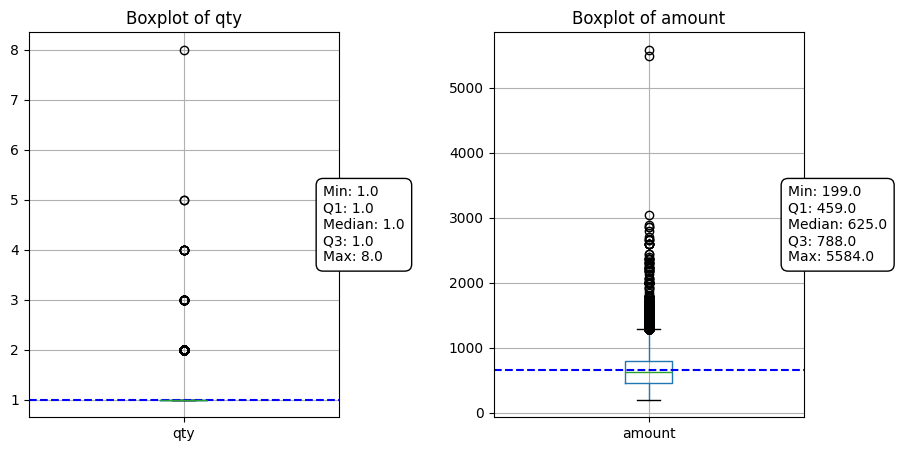

In [67]:
# box plots for investigating outliers in qty and amount columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, col in enumerate(['qty', 'amount']):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].axhline(y=df[col].mean(), color='b', linestyle='dashed')
    
    # adding describe to the boxplots
    stats = df[col].describe()
    text = f"Min: {stats['min']}\nQ1: {stats['25%']}\nMedian: {stats['50%']}\nQ3: {stats['75%']}\nMax: {stats['max']}"
    axes[i].text(0.95, 0.5, text, transform=axes[i].transAxes, verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.subplots_adjust(wspace=0.5)

plt.show()


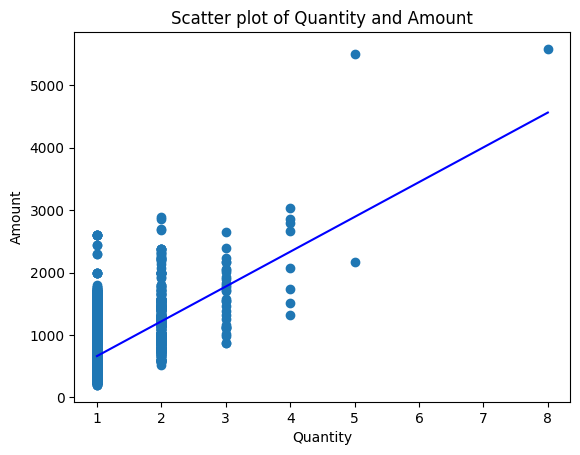

In [68]:
# scatter plot qty and amount
plt.scatter(df['qty'], df['amount'])
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.plot(np.unique(df['qty']), np.poly1d(np.polyfit(df['qty'], df['amount'], 1))(np.unique(df['qty'])), color='blue')
plt.title('Scatter plot of Quantity and Amount')
plt.show()

#### Takeaways:
- Outliers: we can easily see that there are outliers in both qty and amount, we can also see that some of the outliers has a relationship
- If we are using a linear regression model we should probably handle these outliers in some form eg. log transformation
- Overall I find it difficult to determine linearity, I'm leaning towards Decision Tree that can handle non-linear relationships better.

#### Getting a better look at 'category' and 'size'

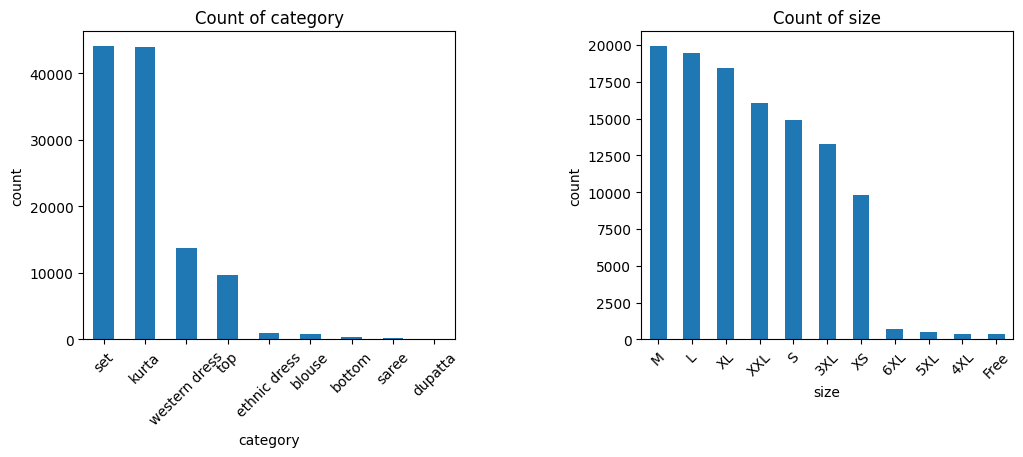

In [69]:
# bar plots for 'category' and 'size'
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, col in enumerate(['category', 'size']):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Count of {col}")
    axes[i].set_ylabel('count')
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.subplots_adjust(wspace=0.5)

plt.show()

#### Testing the LabelEncoder to get a simple correlation heatmap

In [70]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_label = df.copy()


# encode 'category' and 'size' columns
df_label['category_encoded'] = label_encoder.fit_transform(df_label['category'])
df_label['size_encoded'] = label_encoder.fit_transform(df_label['size'])


In [71]:
df_label.head()

,category,size,qty,amount,category_encoded,size_encoded
1,kurta,3XL,1,406.0,4,0
2,kurta,XL,1,329.0,4,8
4,top,3XL,1,574.0,7,0
5,set,XL,1,824.0,6,8
6,set,L,1,653.0,6,5


### Correlation heatmaps

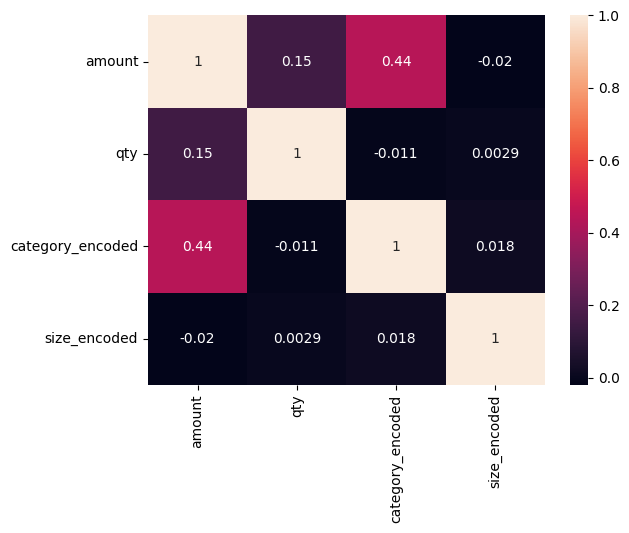

In [72]:
# correlation matrix
corr_cols = ['amount', 'qty', 'category_encoded', 'size_encoded']
correlation_matrix_label = df_label[corr_cols].corr()
sns.heatmap(correlation_matrix_label, annot=True)
plt.show()

#### One-hot encoding 'category' and 'size' to get a broader view of the correlation heatmap

In [73]:
# One-hot encode 'category' and 'size' columns
df_encoded = pd.get_dummies(df, columns=['category', 'size'])

<Axes: >

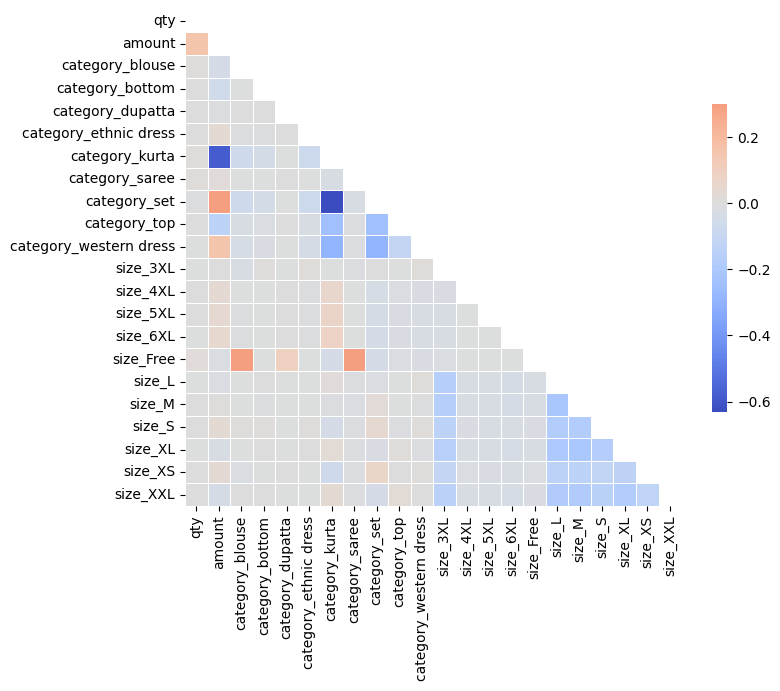

In [74]:
corr = df_encoded.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 8))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Takeaways: <br>
- The heatmap of features shows low correlations between features and the 'amount'. This suggests no single feature strongly predicts the target on its own.
- With these findings in mind, I'm choosing to go with a Decision Tree Regressor model which handles non-linear relationships in the data more effectively than a Linear model.
- Regarding outliers: I researched how to handle outliers when working with Decision Trees and found that the model is not sensitive to outliers, so the plan is to leave it as is for now.

### Model choice: Decision Tree <br>

#### One-hot Encoded vs Label Encoded
##### Decision Tree Regressor can handle both label encoded and one-hot encoded features. However in our case, there isn't a big advantage to for example one-hot encode the nominal 'category' column and then label encode the 'size' column which is ordinal. Another issue with 'size' is that there is a "Free" (one size fits all) which would have to be separated into its own binary column. Since our dataset will be in the (shape: ~110000x21) which is well within the reason to compute, I think we can manage with just one-hot encoding. It also makes it easier to establish Feature Importance.

In [75]:
df.head(1)

,category,size,qty,amount
1,kurta,3XL,1,406.0


In [76]:
# one-hot encode 'category' and 'size' columns
categorical_features = ['category', 'size']
one_hot_encoder = OneHotEncoder()
transformer = ColumnTransformer(transformers=[('cat', one_hot_encoder, categorical_features)], remainder='passthrough')
X = transformer.fit_transform(df.drop('amount', axis=1))

# get feature names
feature_names = transformer.get_feature_names_out()
feature_names_print = feature_names.tolist()
print(feature_names_print)
print(f' count of features: ', len(feature_names_print))

['cat__category_blouse', 'cat__category_bottom', 'cat__category_dupatta', 'cat__category_ethnic dress', 'cat__category_kurta', 'cat__category_saree', 'cat__category_set', 'cat__category_top', 'cat__category_western dress', 'cat__size_3XL', 'cat__size_4XL', 'cat__size_5XL', 'cat__size_6XL', 'cat__size_Free', 'cat__size_L', 'cat__size_M', 'cat__size_S', 'cat__size_XL', 'cat__size_XS', 'cat__size_XXL', 'remainder__qty']
 count of features:  21


### 80/20 Training & Test Split

In [77]:
# split the data into train and test sets
y = df['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Training the model on the 80/20 split first and comparing it to training with cross-validation

In [78]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [79]:
y_pred = decision_tree_model.predict(X_test)
mae = round(mean_absolute_error(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
rmse = round(np.sqrt(mse), 3)
r2 = round(r2_score(y_test, y_pred), 4)
stdev = round(y.std(), 2)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'STDDEV: {stdev}')
print(f'R²: {r2}')

MAE: 140.66
MSE: 37084.46
RMSE: 192.573
STDDEV: 269.54
R²: 0.4994


#### Mean Absolute Error (MAE):
- The MAE value of 140.66 indicates that, on average, our models predictions are about 140.66 INR away from the actual values. This measure gives us the average magnitude of errors in our predictions. Basically, it reflects the average amount by which our predicted 'amounts' differ from the actual 'amounts'.
#### Mean Squared Error (MSE):
- The MSE value of 37084.46 tells us the average squared error of our predictions. A higher MSE indicates larger errors in the models predictions, making it more sensitive to outliers than MAE. Basically, the larger this value is, the worse the model performs in terms of prediction accuracy.
#### Root Mean Squared Error (RMSE):
- The RMSE is essentially the square root of the MSE which brings the value down to the same units as the target variable, making it easier to understand. Like the MSE, a higher value means the model performs worse in terms of prediction accuracy.
#### Standard Deviation (STDDEV):
- The STDDEV of our target variable 'amount' is 269.54, indicating a relatively wide spread of values around the mean. Comparing this to our RMSE of 192.573 which is lower than our STDDEV, we can see that our model performs better than the naive prediction of the mean.
#### Coefficient of determination or R-squared (R²):
- R² is a measure that tells us how much variation in the target variable our model can explain. For example, an R² of 0.4994 means our model explains about 49.94% of the variability in the target variable around its mean. It's a useful indicator of model performance; the closer R² is to 1, the better our model fits the data.

#### Training with cross-validation

In [80]:
from sklearn.model_selection import cross_val_score

cv_decision_tree_model = DecisionTreeRegressor(random_state=42)

cv_mse_scores = cross_val_score(cv_decision_tree_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_mean = round(-cv_mse_scores.mean(), 3) # turning negative values to positive
cv_rmse_mean = round(np.sqrt(cv_mse_mean), 3)
cv_r2_scores = cross_val_score(cv_decision_tree_model, X, y, cv=5, scoring='r2')
cv_r2_mean = round(cv_r2_scores.mean(), 4)
cv_mae_scores = cross_val_score(cv_decision_tree_model, X, y, cv=5, scoring='neg_mean_absolute_error')

#print(f'CV MAE: {cv_mae_scores}')
print(f'CV MSE: {cv_mse_mean}')
print(f'CV RMSE: {cv_rmse_mean}')
print(f'CV R²: {cv_r2_mean}')

CV MSE: 37029.621
CV RMSE: 192.431
CV R²: 0.4894


#### The fact that training on 80/20 and with cross-validation had such a small difference in performance is a good indication that our model isn't overfitting

In [81]:
# training with fine-tuned hyperparameters
tuned_decision_tree_model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
tuned_decision_tree_model.fit(X_train, y_train)

tuned_y_pred = tuned_decision_tree_model.predict(X_test)
tuned_mae = round(mean_absolute_error(y_test, tuned_y_pred), 3)
tuned_mse = round(mean_squared_error(y_test, tuned_y_pred), 3)
tuned_rmse = round(np.sqrt(tuned_mse), 3)
tuned_r2 = round(r2_score(y_test, tuned_y_pred), 4)
print(f'Tuned MAE: {tuned_mae}')
print(f'Tuned MSE: {tuned_mse}')
print(f'Tuned RMSE: {tuned_rmse}')
print(f'Tuned R²: {tuned_r2}')

Tuned MAE: 141.387
Tuned MSE: 37976.943
Tuned RMSE: 194.877
Tuned R²: 0.4873


#### No improvements after fine-tuning hyperparameters either. <br>
#### I have tried many different ways of improving performance but I keep hitting the same or near R² score. I'm starting to think that I have reached a limit with this particular set of features and target variables. 

#### Visualizing the decision tree (for fun)

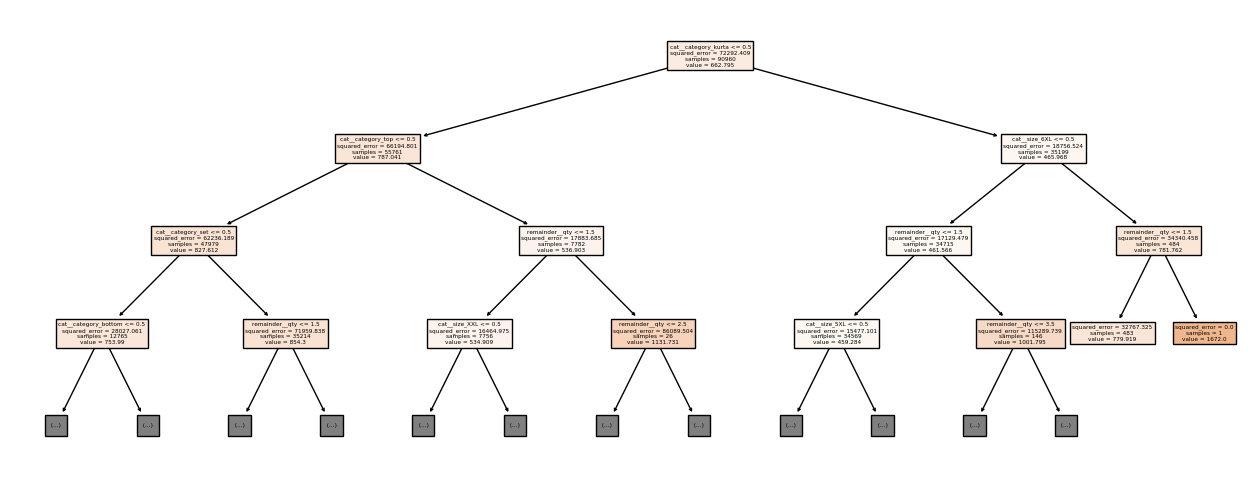

In [82]:
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 6))
plot_tree(decision_tree_model, filled=True, feature_names=feature_names_print, max_depth=3)
plt.show()

#### Feature Importance
- Tried a different variations of features using the importance analysis below but saw no improvements to my models performacne.

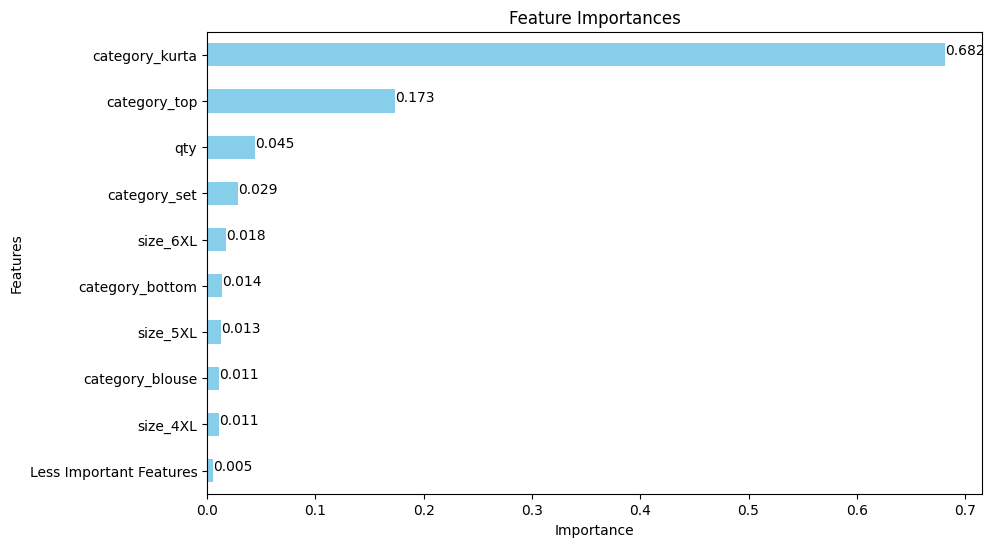

In [83]:
feature_importances = decision_tree_model.feature_importances_
encoded_feature_names = transformer.named_transformers_['cat'].get_feature_names_out(categorical_features)
remaining_feature_names = [name for name in df.drop(columns=categorical_features + ['amount']).columns]
all_feature_names = list(encoded_feature_names) + remaining_feature_names
importances_series = pd.Series(feature_importances, index=all_feature_names)

# threshold for clustering low importance features
threshold = 0.01 

important_features = importances_series[importances_series >= threshold]
less_important_features_sum = importances_series[importances_series < threshold].sum()

clustered_importances_series = pd.concat([important_features, pd.Series([less_important_features_sum], index=['Less Important Features'])])

# sort descending
sorted_importances_series = clustered_importances_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6)) 
sorted_importances_series.plot(kind='barh', color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
for index, value in enumerate(sorted_importances_series):
    plt.text(value, index, str(round(value, 3)))
plt.gca().invert_yaxis()
plt.show()

## Project Conclusion

What I learned:
- Preprocessing and Feature Engineering for a Decision Tree Regression model was more simple compared to Linear Regression model.
- The performance when using cross-validation showed that our model is stable and not overfitting.
- Despite attempts at hyperparameter tuning and testing other models like SVR, Linear Regression, Random Forest, and Gradient Boosting, we hit a performance ceiling with an R² score around 0.494, indicating that about half of the variance in the spending amount is predictable from our features.
- The Decision Tree Regressors performance plateau suggests we might have reached the limits of what the current dataset can offer.

Conclusions:
- After spending alot of time digging into the data and training the model so many times with different approaches, my opinion is that I have reached the limit of what I can accomplish with this dataset, with my current capabilities.
- As this was my first real end to end ML project, I learned alot from working on it. In my opinion working through problems in a project is the best way to learn.
- One downside is the performance plateau which I hit early on and spent alot of time trying to improve without getting better results, which was a little demotivating but at the same time this probably something that happens in real-world ML projects. It would've been fun to see more improvements after doing some work to the features or after fine-tuning the model.